In [5]:
%reset -f

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA



<div style="text-align: right;">
	<h1 style="display: inline-block;margin: 0;padding: 8px 16px;color: white;background: linear-gradient(to right,rgb(17, 75, 141), #4CAF50);border-radius: 12px;font-size: 1.8rem;box-shadow: 0 4px 10px rgba(0, 0, 0, 0.3);"> teoría </h1>
</div>


Modelo PLN arquitectura seq2seq  (sequence-to-sequence) con:
- Encoder: Procesa la oración en inglés
- Decoder: Genera la traducción en españo



 Frameworks para crear modelos seq2seq
 20
 Algunos frameworks/librerías que traen modelos e interfaces 
preparadas para armar rápidamente un sistema basado en NLP

Hola.

**Seq2Seq** (sequence-to-sequence), que es el nombre de la arquitectura, y las partes que la componen, Encoder LSTM y Decoder LSTM.

- Seq2Seq: Es el nombre del tipo de arquitectura o esquema general que se usa para transformar una secuencia en otra. Por ejemplo, traducir una oración de inglés a español, resumir un texto largo, o generar una respuesta en un chat.

- Encoder LSTM: Es el componente de la arquitectura Seq2Seq que se encarga de procesar la secuencia de entrada. En este caso, el componente es una red neuronal de tipo LSTM (Long Short-Term Memory), que es un tipo especializado de RNN (Recurrent Neural Network) muy bueno para capturar las dependencias en secuencias de datos. El encoder "lee" la oración palabra por palabra y la comprime en un vector de contexto.

- Decoder LSTM: Es el otro componente de la arquitectura Seq2Seq que se encarga de generar la secuencia de salida, también usando una red LSTM. El decoder toma el vector de contexto del encoder y, basándose en este y en las palabras que ya ha generado, predice la siguiente palabra de la secuencia de salida.

In [6]:
# descarga del dataset desde kagglehub
# Instalamos librerias
try:
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.text import one_hot 
    from tqdm import tqdm
    #import gdown
    print("Todas las librerías ya están instaladas")
except ImportError:
    !pip install tqdm
    #!pip install --upgrade --no-cache-dir gdown
    !pip install keras tensorflow
    print("Instalación completada")
    from tqdm import tqdm





Todas las librerías ya están instaladas


### 1 - Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT  de preguntas y respuestas (Question and answers Bot QA-bot) para responder a preguntas del usuario (QA). [LINK](http://convai.io/data/) utilizaremos al arquitectura de modelo **Seq2Seq** (sequence-to-sequence)

In [7]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [8]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf

import re  # Faltaba esta importación

from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer librerias viejas 
#from keras.preprocessing.text import one_hot librerias viejas 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot  
from keras.layers import Input

# Descarga y preparación del dataset


In [9]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    #url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    url = 'http://convai.io/data/data_volunteers.json'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [10]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



<div style="text-align: right;">
	<h1 style="display: inline-block;margin: 0;padding: 8px 16px;color: white;background: linear-gradient(to right,rgb(17, 75, 141), #4CAF50);border-radius: 12px;font-size: 1.8rem;box-shadow: 0 4px 10px rgba(0, 0, 0, 0.3);">⚠️ desarrollar </h1>
</div>

# Ejecutar con modelos 
- GloVe 50d 
- FastText 50d 

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.



In [11]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [12]:
import pprint

# Ver las primeras líneas del JSON original
print("Tipo de datos:", type(data))
print("Cantidad de elementos:", len(data))
print("\nPrimeros 2 elementos:")

pprint.pprint(data[:2])

Tipo de datos: <class 'list'>
Cantidad de elementos: 1111

Primeros 2 elementos:
[{'bot_profile': ['i like to talk but people have a hard time understanding.',
                  'i like to look at blocks and sing about letters.',
                  'i like to eat chocolate candy.',
                  'when i grow up i want to be a dog.'],
  'dialog': [{'evaluation_score': None,
              'id': 0,
              'sender': 'participant1',
              'sender_class': 'Human',
              'text': 'hi there'}],
  'end_time': '2018-10-29 03:32:08.296000',
  'eval_score': None,
  'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
  'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'},
  'profile_match': '',
  'start_time': '2018-10-29 03:32:08.296000',
  'user_profile': ['i am a clean eater.',
                   'my parents were both very athletic.',
                   'i love running and preparing for marathons.',
                   'i am a cancer survivor.']},
 {'bot_p

In [13]:
# Ver la estructura de un diálogo completo
print("Estructura del datset:")
print("Keys disponibles:", data[0].keys())
print("\nPrimer diálogo completo:")
pprint.pprint(data[0])

Estructura del datset:
Keys disponibles: dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

Primer diálogo completo:
{'bot_profile': ['i like to talk but people have a hard time understanding.',
                 'i like to look at blocks and sing about letters.',
                 'i like to eat chocolate candy.',
                 'when i grow up i want to be a dog.'],
 'dialog': [{'evaluation_score': None,
             'id': 0,
             'sender': 'participant1',
             'sender_class': 'Human',
             'text': 'hi there'}],
 'end_time': '2018-10-29 03:32:08.296000',
 'eval_score': None,
 'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
 'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'},
 'profile_match': '',
 'start_time': '2018-10-29 03:32:08.296000',
 'user_profile': ['i am a clean eater.',
                  'my parents were both very athletic.',
     

### 2 - Preprocesamiento


Se realiza la limpieza de los datos para que pueda ser utilizado en el modelo de red neuronal de tipo  Sequence to Sequence **Seq2Seq**. 

Tomamos las conversaciones crudas del archivo JSON, dividirlas en pares de "pregunta-respuesta", limpiar el texto y formatearlo de una manera muy específica que los modelos como LSTM necesitan para aprender a conversar.

#### Algunas configuraciones relavantes para el QA-bot (Question and Answer bot)

- max_len = 30: Define la longitud máxima (en caracteres) que una oración puede tener. Si la pregunta o la respuesta superan este límite, se descartan. Esto se hace para mantener la uniformidad y evitar que el modelo procese textos excesivamente largos

In [14]:
# Preparación del DataSet. 
chat_in = [] # Variable temporal donde se guardará cada frase de entrada (pregunta).
chat_out = [] # Variable temporal donde se guardará cada frase de salida (respuesta).

input_sentences = []  # se guardarán todas las "preguntas" (las frases de entrada para el modelo).
output_sentences = [] # se guardarán las "respuestas" que el modelo debe aprender a generar, , terminadas con <eos>.
# modificada de las respuestas que se usa para "enseñarle" al modelo durante el entrenamiento (un concepto llamado teacher forcing)
output_sentences_inputs = [] # Respuestas de entrada al decodificador, empezadas con <sos>.
max_len = 30 # Define la longitud máxima (en caracteres) que una oración puede tener.


# Función para limpiar el texto (preprocesamiento básico)
def clean_text(txt): 
    txt = txt.lower()               # Convierte todo el texto a minúsculas
    txt.replace("\'d", " had")      # I'd -> I had
    txt.replace("\'s", " is")       # She's -> She is
    txt.replace("\'m", " am")       # I'm -> I am
    txt.replace("don't", "do not")  # don't -> do not
    # Eliminación de caracteres que no sean letras, números o guiones bajos
    # Reemplaza por un espacio cualquier cosa que no sea alfanumérica
    txt = re.sub(r'\W+', ' ', txt) 
    # ejemplo 
    #        re.sub(r'\W+', ' ', "Hello!!! How's it going?")  
    #                             → "Hello How s it going "


    
    return txt
# Iteramos por cada "línea" (registro) en el dataset JSON
for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # Cada registro contiene un diálogo (lista de frases).
        # y "respuestas" (chat_out)
        # Vamos a emparejar cada oración con la siguiente (pregunta-respuesta).
        chat_in = clean_text(line['dialog'][i]['text']) # Extraemos y limpiamos el texto de la pregunta
        chat_out = clean_text(line['dialog'][i+1]['text']) # Extraemos y limpiamos el texto de la respuesta

        # Si la pregunta o respuesta excede la longitud máxima, la descartamos
        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        # La salida del decodificador (respuesta esperada) termina con <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        # La entrada del decodificador (teacher forcing) empieza con <sos>
        output_sentence_input = '<sos> ' + output

        # Añadimos a las listas finales
        input_sentences.append(input_sentence)      # Pregunta limpia
        output_sentences.append(output_sentence)    # Respuesta con <eos>
        output_sentences_inputs.append(output_sentence_input)   # Respuesta con <sos>

# Mostramos cuántas parejas de frases válidas quedaron - pares de pregunta-respuesta procesados
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [15]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

In [16]:
# Ver ejemplos de conversaciones procesadas
print("=== EJEMPLOS DE CONVERSACIONES ===")
for i in range(5):
    print(f"\nEjemplo {i+1}:")
    print(f"INPUT:  {input_sentences[i]}")
    print(f"OUTPUT: {output_sentences[i]}")
    print(f"OUTPUT_INPUT: {output_sentences_inputs[i]}")

=== EJEMPLOS DE CONVERSACIONES ===

Ejemplo 1:
INPUT:  hello 
OUTPUT: hi how are you  <eos>
OUTPUT_INPUT: <sos> hi how are you 

Ejemplo 2:
INPUT:  hi how are you 
OUTPUT: not bad and you  <eos>
OUTPUT_INPUT: <sos> not bad and you 

Ejemplo 3:
INPUT:  hi 
OUTPUT: hello  <eos>
OUTPUT_INPUT: <sos> hello 

Ejemplo 4:
INPUT:  hi 
OUTPUT: hello  <eos>
OUTPUT_INPUT: <sos> hello 

Ejemplo 5:
INPUT:  hi 
OUTPUT: hello how are you today  <eos>
OUTPUT_INPUT: <sos> hello how are you today 


In [17]:
# Análisis de longitudes
#import pandas as pd

df_analysis = pd.DataFrame({
    'input_len': [len(s.split()) for s in input_sentences],
    'output_len': [len(s.split()) for s in output_sentences]
})

print("=== ESTADÍSTICAS ===")
print(df_analysis.describe())

=== ESTADÍSTICAS ===
         input_len   output_len
count  6033.000000  6033.000000
mean      3.777557     5.050390
std       2.126842     2.074806
min       0.000000     1.000000
25%       2.000000     3.000000
50%       4.000000     5.000000
75%       5.000000     7.000000
max       9.000000    10.000000


In [ ]:
# ============================================================================
# v3.PREPROCESAMIENTO - QA BOT
# ============================================================================

# Imports necesarios
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
import numpy as np




# CONFIGURACIÓN DE HIPERPARÁMETROS
# ==================================

# Configuración del vocabulario y secuencias
#MAX_VOCAB_SIZE = 4000 ->  error i an vegan
MAX_VOCAB_SIZE = 8000      # Vocabulario máximo (conservador para RAM) 4000
max_input_len = 10         # Longitud máxima de preguntas (palabras)
max_out_len = 12          # Longitud máxima de respuestas (palabras)

print(f"Configuración:")
print(f"- MAX_VOCAB_SIZE: {MAX_VOCAB_SIZE}")
print(f"- max_input_len: {max_input_len}")  
print(f"- max_out_len: {max_out_len}")
print(f"- Dataset disponible: {len(input_sentences)} pares pregunta y respuesta \n")


# CREAR TOKENIZERS 
# ==============================================================

# Tokenizer para las PREGUNTAS (input)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

# Tokenizer para las RESPUESTAS (output)
# IMPORTANTE: Quitamos '<' y '>' de los filtros para conservar <sos> y <eos>
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, 
    filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
)

# Ajustar tokenizer con los tokens especiales y todas las respuestas
all_output_sentences = ["<sos>", "<eos>"] + output_sentences + output_sentences_inputs
output_tokenizer.fit_on_texts(all_output_sentences)

# Convertir respuestas a secuencias numéricas
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)



# GENERAR DICCIONARIOS PALABRA→ÍNDICE
# =================================

# Diccionarios para convertir palabras a índices
word2idx_inputs = input_tokenizer.word_index
word2idx_outputs = output_tokenizer.word_index

# Calcular longitudes máximas reales del dataset (ANTES del filtrado)
max_input_len_real = max(len(sen) for sen in input_integer_seq)
max_out_len_real = max(len(sen) for sen in output_integer_seq)

# Información del vocabulario
# IMPORTANTE: +1 para incluir el índice 0 (padding) en el conteo
num_words_input = min(len(word2idx_inputs) + 1, MAX_VOCAB_SIZE)
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

print(f"info  del vocabulario:")
print(f"- Palabras únicas en preguntas: {len(word2idx_inputs)}")
print(f"- Palabras únicas en respuestas: {len(word2idx_outputs)}")
print(f"- Vocabulario final inputs: {num_words_input}")
print(f"- Vocabulario final outputs: {num_words_output}")
print(f"- Longitud máxima real inputs: {max_input_len_real}")
print(f"- Longitud máxima real outputs: {max_out_len_real}")

# Verificar que los tokens especiales estén presentes
if '<sos>' in word2idx_outputs and '<eos>' in word2idx_outputs:
    print(" Tokens especiales <sos> y <eos> encontrados")
    print(f"- Índice <sos>: {word2idx_outputs['<sos>']}")
    print(f"- Índice <eos>: {word2idx_outputs['<eos>']}")
else:
    print(" ERROR: Tokens especiales no encontrados!")


# CONVERTIR TEXTO A SECUENCIAS NUMÉRICAS
# ============================================================================

# IMPORTANTE: Filtrar índices que excedan MAX_VOCAB_SIZE
def filter_sequences(sequences, max_vocab):
    """Reemplaza índices >= max_vocab con 1 (palabra desconocida)"""
    filtered = []
    for seq in sequences:
        filtered_seq = [idx if idx < max_vocab else 1 for idx in seq]
        filtered.append(filtered_seq)
    return filtered

# Filtrar secuencias de entrada
input_integer_seq_filtered = filter_sequences(input_integer_seq, MAX_VOCAB_SIZE)
output_integer_seq_filtered = filter_sequences(output_integer_seq, MAX_VOCAB_SIZE)
output_input_integer_seq_filtered = filter_sequences(output_input_integer_seq, MAX_VOCAB_SIZE)

# ENCODER: Secuencias de entrada (preguntas)
# Padding al INICIO para que las últimas palabras sean más relevantes
encoder_input_sequences = pad_sequences(
    input_integer_seq_filtered, 
    maxlen=max_input_len,
    padding='pre'  # Padding al inicio
)

# DECODER INPUT: Secuencias que empiezan con <sos> 
# Padding al FINAL porque necesitamos la secuencia completa
decoder_input_sequences = pad_sequences(
    output_input_integer_seq_filtered,
    maxlen=max_out_len, 
    padding='post'  # Padding al final
)

# DECODER OUTPUT: Secuencias que terminan con <eos>
# Estas son los "targets" que el modelo debe predecir
decoder_output_sequences = pad_sequences(
    output_integer_seq_filtered,
    maxlen=max_out_len,
    padding='post'  # Padding al final
)



# CREAR TARGETS EN FORMATO ONE-HOT
# ======================================

# Convirtiendo targets a formato one-hot
# Verificación de seguridad: revisar el rango de índices
max_idx_in_sequences = np.max(decoder_output_sequences)
print(f"\nVerificación de índices:")
print(f"- Índice máximo en secuencias: {max_idx_in_sequences}")
print(f"- num_words_output: {num_words_output}")

# Ajustar num_classes si es necesario
num_classes = max(num_words_output, max_idx_in_sequences + 1)
print(f"- num_classes ajustado: {num_classes}")

# Convertir las secuencias de salida a formato one-hot para la función de pérdida
decoder_targets = to_categorical(
    decoder_output_sequences, 
    num_classes=num_classes
)

print(f" Shape de targets one-hot: {decoder_targets.shape}")
print(f"- Cada posición tiene {num_classes} clases posibles")

# Actualizar num_words_output para mantener consistencia
num_words_output = num_classes

# Crear diccionarios inversos para debugging
idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v: k for k, v in word2idx_outputs.items()}

print("\n--- Verificación de diccionarios inversos ---")
print(f"idx2word_inputs creado: {len(idx2word_inputs)} palabras")
print(f"idx2word_outputs creado: {len(idx2word_outputs)} palabras")


Configuración:
- MAX_VOCAB_SIZE: 8000
- max_input_len: 10
- max_out_len: 12
- Dataset disponible: 6033 pares pregunta y respuesta 

info  del vocabulario:
- Palabras únicas en preguntas: 1799
- Palabras únicas en respuestas: 1806
- Vocabulario final inputs: 1800
- Vocabulario final outputs: 1807
- Longitud máxima real inputs: 9
- Longitud máxima real outputs: 10
 Tokens especiales <sos> y <eos> encontrados
- Índice <sos>: 1
- Índice <eos>: 2

Verificación de índices:
- Índice máximo en secuencias: 1806
- num_words_output: 1807
- num_classes ajustado: 1807
 Shape de targets one-hot: (6033, 12, 1807)
- Cada posición tiene 1807 clases posibles

--- Verificación de diccionarios inversos ---
idx2word_inputs creado: 1799 palabras
idx2word_outputs creado: 1806 palabras


In [ ]:
# ============================================================================
#  PREPARAR EMBEDDINGS ----- GLOVE
# ============================================================================

# Imports necesarios para embeddings
import os
import gdown
import pickle
import logging
import numpy as np
from pathlib import Path
from io import StringIO




# DESCARGAR EMBEDDINGS GLOVE PRE-ENTRENADOS
# ============================================================================

print("\n--- Descargando embeddings GloVe ---")

# Descargar embeddings GloVe 50d desde Google Drive
if not os.access('gloveembedding.pkl', os.F_OK):
    print("Descargando gloveembedding.pkl...")
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
    print("Descarga completada")
else:
    print("gloveembedding.pkl ya está disponible")


# IMPLEMENTAR CLASES PARA MANEJAR EMBEDDINGS
# ============================================================================

print("\n--- Implementando clases para embeddings ---")

class WordsEmbeddings(object):
    """Clase base para manejar embeddings de palabras"""
    
    logger = logging.getLogger(__name__)

    def __init__(self):
        # Cargar embeddings desde archivo pickle o texto
        words_embedding_pkl = Path(self.PKL_PATH)
        
        if not words_embedding_pkl.is_file():
            # Si no existe el pickle, buscar archivo de texto original
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), f'Words embedding not available at {self.WORD_TO_VEC_MODEL_TXT_PATH}'
            print(f"Convirtiendo {self.WORD_TO_VEC_MODEL_TXT_PATH} a pickle...")
            embeddings = self.convert_model_to_pickle()
        else:
            # Cargar desde pickle pre-existente
            print(f"Cargando embeddings desde {self.PKL_PATH}")
            embeddings = self.load_model_from_pickle()
            
        self.embeddings = embeddings
        
        # Construir mapeos palabra <-> índice
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))
        
        print(f"Embeddings cargados: {len(self.embeddings)} palabras, {self.N_FEATURES} dimensiones")

    def get_words_embeddings(self, words):
        """Obtener vectores de embedding para una lista de palabras"""
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        """Convertir palabras a índices"""
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        """Convertir índices a palabras"""
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        """Cargar embeddings desde archivo pickle"""
        self.logger.debug(f'Loading embeddings from pickle {self.PKL_PATH}')
        
        # Manejo de archivos grandes (hasta 256MB por chunk)
        max_bytes = 2**28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
                
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('Embeddings loaded successfully')
        return embeddings

    def convert_model_to_pickle(self):
        """Convertir archivo de texto a formato pickle para carga rápida"""
        self.logger.debug(f'Converting embeddings from {self.WORD_TO_VEC_MODEL_TXT_PATH}')
        
        # Crear estructura de array NumPy: palabra + vector de embeddings
        structure = [
            ('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
            ('embedding', np.float32, (self.N_FEATURES,))
        ]
        structure = np.dtype(structure)
        
        # Cargar desde archivo de texto usando generador (eficiente en memoria)
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) 
                for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
            
        # Agregar embedding nulo para palabras desconocidas
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        
        # Guardar como pickle para cargas futuras más rápidas
        max_bytes = 2**28 - 1
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
                
        self.logger.debug('Embeddings converted and saved to pickle')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    """Implementación específica para embeddings GloVe 50d"""
    
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'  # Archivo original (si fuera necesario)
    PKL_PATH = 'gloveembedding.pkl'  # Archivo pickle descargado
    N_FEATURES = 50                  # Dimensiones del embedding
    WORD_MAX_SIZE = 60              # Longitud máxima de palabras


class FasttextEmbeddings(WordsEmbeddings):
    """Implementación para FastText (disponible para futura experimentación)"""
    
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60


# CARGAR MODELO GLOVE
# ===============================

print("\n--- Cargando modelo GloVe ---")

# Configuración de logging para debugging
logging.basicConfig(level=logging.INFO)

# Cargar embeddings GloVe 50d
print("Inicializando GloVe embeddings...")
model_embeddings = GloveEmbeddings()

# Configuración de embeddings para el modelo
embed_dim = model_embeddings.N_FEATURES
print(f"Configuración de embeddings:")
print(f"- Dimensiones: {embed_dim}")
print(f"- Vocabulario total: {len(model_embeddings.embeddings)}")
print(f"- Archivo fuente: {model_embeddings.PKL_PATH}")


# CREAR EMBEDDING MATRIX PARA EL VOCABULARIO
# =================================================================


# Variables del preprocesamiento (deben estar disponibles de la Etapa 1)
print(f"Variables disponibles:")
print(f"- num_words_input: {num_words_input}")
print(f"- Tamaño del vocabulario de entrada: {len(word2idx_inputs)}")

# Inicializar matriz de embeddings
# MAX_VOCAB_SIZE=4000 palabras x 50 dimensiones
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))+1
embedding_matrix = np.zeros((nb_words, embed_dim))
words_not_found = []

""" 
porque + 1 -> nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))+1
EEERRROO
len(word2idx_inputs) = 1799 palabras únicas
MAX_VOCAB_SIZE = 4000  # ok-- Esto está bien (es el límite máximo)

# El cálculo era:
nb_words = min(4000, 1799) = 1799  # ERROR-- Problema aquí

# Pero el tokenizer usa índices 1-1799
# La embedding esperaba rango 0-1798
# Resultado: índice 1799 está fuera de rango

"""



print(f"Creando matriz de embeddings {nb_words} x {embed_dim}...")

# Llenar matriz con embeddings pre-entrenados
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
        
    # Obtener vector de embedding para la palabra
    embedding_vector = model_embeddings.get_words_embeddings([word])[0]
    
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # Si la palabra existe en GloVe, usar su vector
        embedding_matrix[i] = embedding_vector
    else:
        # Si no existe, quedará como vector de ceros
        words_not_found.append(word)

# Estadísticas de cobertura
total_words = len(word2idx_inputs)
found_words = total_words - len(words_not_found)
coverage = (found_words / total_words) * 100

print(f" Estadísticas de embedding matrix:")
print(f"- Shape final: {embedding_matrix.shape}")
print(f"- Palabras encontradas en GloVe: {found_words}/{total_words} ({coverage:.1f}%)")
print(f"- Palabras no encontradas: {len(words_not_found)}")
print(f"- Embeddings nulos: {np.sum(np.sum(embedding_matrix**2, axis=1) == 0)}")


# VERIFICACIONES Y EJEMPLOS
# ===============================

print("\n--- Verificaciones de embeddings ---")

# Probar algunas palabras comunes
test_words = ['hello', 'good', 'how', 'you', 'are', 'what']
print("Probando palabras comunes:")

for word in test_words:
    if word in word2idx_inputs:
        idx = word2idx_inputs[word]
        if idx < nb_words:
            vector_norm = np.linalg.norm(embedding_matrix[idx])
            status = "Encontrada" if vector_norm > 0 else " No encontrada"
            print(f"  '{word}' (idx={idx}): {status} (norma={vector_norm:.3f})")
    else:
        print(f"  '{word}':  No está en vocabulario")

# Mostrar algunas palabras no encontradas (si las hay)
if words_not_found:
    print(f"\nPrimeras 10 palabras no encontradas en GloVe:")
    for word in words_not_found[:10]:
        print(f"  - '{word}'")

# PREPARAR CAPA DE EMBEDDING PARA KERAS
# ===================================

print("\n--- Preparando capa de Embedding ---")

from tensorflow.keras.layers import Embedding

# Crear capa de embedding con pesos pre-entrenados
encoder_embedding_layer = Embedding(
    input_dim=nb_words,              # Tamaño del vocabulario
    output_dim=embed_dim,            # Dimensiones del embedding (50)
    input_length=max_input_len,      # Longitud máxima de secuencias
    weights=[embedding_matrix],      # Matriz de embeddings pre-entrenados
    trainable=False,                 # No entrenar los embeddings (usar como están)
    name='encoder_embedding'
)

print(f"Capa de embedding creada:")
print(f"- input_dim: {nb_words}")
print(f"- output_dim: {embed_dim}")
print(f"- input_length: {max_input_len}")
print(f"- trainable: False (embeddings congelados)")





--- Descargando embeddings GloVe ---
gloveembedding.pkl ya está disponible

--- Implementando clases para embeddings ---

--- Cargando modelo GloVe ---
Inicializando GloVe embeddings...
Cargando embeddings desde gloveembedding.pkl
Embeddings cargados: 1193514 palabras, 50 dimensiones
Configuración de embeddings:
- Dimensiones: 50
- Vocabulario total: 1193514
- Archivo fuente: gloveembedding.pkl
Variables disponibles:
- num_words_input: 1800
- Tamaño del vocabulario de entrada: 1799
Creando matriz de embeddings 1800 x 50...
 Estadísticas de embedding matrix:
- Shape final: (1800, 50)
- Palabras encontradas en GloVe: 1799/1799 (100.0%)
- Palabras no encontradas: 0
- Embeddings nulos: 139

--- Verificaciones de embeddings ---
Probando palabras comunes:
  'hello' (idx=19): Encontrada (norma=4.874)
  'good' (idx=24): Encontrada (norma=6.277)
  'how' (idx=10): Encontrada (norma=6.528)
  'you' (idx=2): Encontrada (norma=7.152)
  'are' (idx=7): Encontrada (norma=7.063)
  'what' (idx=4): Encon

c:\Users\SAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



 RESUMEN DEL MODELO:


c:\Users\SAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "seq2seq_qa_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 10, 50)    │     90,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 12, 64)    │    115,648 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 64),      │     29,440 │ encoder_embeddin… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 12, 64),  │     33,024 │ decoder_embeddin… │
│                     │ (None, 64),       │            │ encoder_lstm[0][… │
│                     │ (None, 64)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 12, 1807)  │    117,455 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 385,567 (1.47 MB)

 Trainable params: 295,567 (1.13 MB)

 Non-trainable params: 90,000 (351.56 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Diagrama guardado: seq2seq_model.png
You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.
Diagramas de inferencia guardados

--- INICIANDO ENTRENAMIENTO ---
 Entrenando con 6033 ejemplos...
Datos de entrenamiento: 4826
Datos de validación: 1207

Verificación de datos:
- encoder_input_sequences shape: (6033, 10)
- decoder_input_sequences shape: (6033, 12)
- decoder_targets shape: (6033, 12, 1807)

Iniciando entrenamiento por 50 épocas...
Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5321 - loss: 4.8959 - val_accuracy: 0.6553 - val_loss: 2.0018
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6635 - loss: 1.8904 - val_accuracy: 0.6936 - val_loss: 1.8330
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6818 - loss: 1.7295 - val_accuracy: 0.7054 - val_loss: 1.7572
Epoch 4/50
1

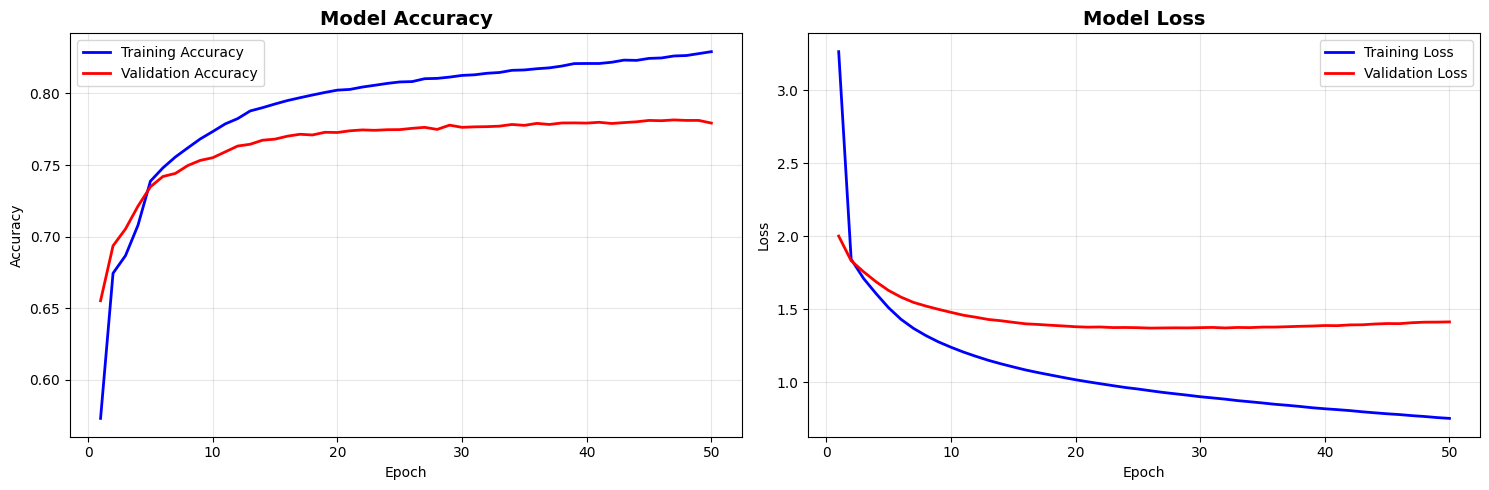


ESTADÍSTICAS FINALES:
Accuracy final:
  - Entrenamiento: 0.8291 (82.91%)
  - Validación: 0.7793 (77.93%)
Loss final:
  - Entrenamiento: 0.7541
  - Validación: 1.4145
Modelo balanceado (diferencia: 0.0498)
El modelo ha aprendido de 6033 conversaciones
Accuracy de validación: 77.93%


In [20]:
# ============================================================================
# ENTRENAR MODELO ENCODER-DECODER
# ============================================================================

# Imports necesarios para el modelo
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns


# CONFIGURACIÓN DE HIPERPARÁMETROS DEL MODELO
# ============================================================================
# Configuración de la red neuronal
n_units = 64               # Unidades LSTM (empezar conservador)
epochs = 50                # Número de épocas de entrenamiento
batch_size = 32            # Tamaño del batch
validation_split = 0.2     # 20% para validación


# ENCODER: Procesa las preguntas de entrada
# ====================


# Input del encoder: secuencias de preguntas
encoder_inputs = Input(shape=(max_input_len,), name='encoder_inputs')

# Capa de embedding (ya preparada en Etapa 2)
encoder_inputs_embedded = encoder_embedding_layer(encoder_inputs)


# LSTM del encoder: procesa la secuencia y retorna estados finales
encoder_lstm = LSTM(
    n_units, 
    return_state=True,        # Retornar estados h y c
    dropout=0.2,              # Dropout para regularización
    recurrent_dropout=0.2,    # Dropout en conexiones recurrentes
    name='encoder_lstm'
)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs_embedded)
encoder_states = [state_h, state_c]  # Estados que se pasan al decoder

# DECODER: Genera las respuestas
# Input del decoder: secuencias que empiezan con <sos>
decoder_inputs = Input(shape=(max_out_len,), name='decoder_inputs')


# Embedding layer para el decoder (se entrena desde cero)
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=n_units,           # Misma dimensión que LSTM
    input_length=max_out_len,
    trainable=True,               # Esta sí se entrena
    name='decoder_embedding'
)

decoder_inputs_embedded = decoder_embedding_layer(decoder_inputs)


# LSTM del decoder: usa los estados del encoder como estado inicial
decoder_lstm = LSTM(
    n_units,
    return_sequences=True,        # Retornar secuencia completa
    return_state=True,            # También retornar estados
    dropout=0.2,
    recurrent_dropout=0.2,
    name='decoder_lstm'
)

# El decoder usa los estados del encoder como punto de partida
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_embedded, 
    initial_state=encoder_states  # ¡Aquí está la magia del seq2seq!
)


# Capa densa final: convierte estados LSTM a distribución de probabilidades
decoder_dense = Dense(
    num_words_output, 
    activation='softmax',
    name='decoder_dense'
)
decoder_outputs = decoder_dense(decoder_outputs)



# MODELO COMPLETO: Para entrenamiento
# Modelo que conecta entradas con salidas. Modelo seq2seq creado
model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs,
    name='seq2seq_qa_model'
)


#  COMPILAR EL MODELO
# ====================

# Configurar función de pérdida y optimizador
model.compile(
    optimizer='adam',                    # Optimizador Adam (adaptativo)
    loss='categorical_crossentropy',     # Pérdida para clasificación multiclase
    metrics=['accuracy']                 # Métrica para monitorear progreso
)


# Mostrar resumen del modelo
print("\n RESUMEN DEL MODELO:")
model.summary()

# CREAR MODELOS PARA INFERENCIA (PREPARAR PARA ETAPA 5)
# =================================

# ENCODER MODEL: Solo para extraer estados


encoder_model = Model(
    inputs=encoder_inputs, 
    outputs=encoder_states,
    name='encoder_inference'
)


# DECODER MODEL: Para generación palabra por palabra


# Inputs para los estados del decoder
decoder_state_input_h = Input(shape=(n_units,), name='decoder_state_h')
decoder_state_input_c = Input(shape=(n_units,), name='decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Input para una sola palabra (durante inferencia)
decoder_inputs_single = Input(shape=(1,), name='decoder_single_input')
decoder_inputs_single_embedded = decoder_embedding_layer(decoder_inputs_single)

# LSTM del decoder para inferencia
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_inputs_single_embedded, 
    initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

# Capa densa final
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

# Modelo del decoder para inferencia
decoder_model = Model(
    inputs=[decoder_inputs_single] + decoder_states_inputs,
    outputs=[decoder_outputs_inf] + decoder_states_inf,
    name='decoder_inference'
)

#  VISUALIZAR ARQUITECTURA
# ===

try:
    # Diagrama del modelo completo
    plot_model(model, to_file='seq2seq_model.png', show_shapes=True, show_layer_names=True)
    print("Diagrama guardado: seq2seq_model.png")
    
    # Diagramas de los modelos de inferencia
    plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)
    plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)
    print("Diagramas de inferencia guardados")
    
except ImportError:
    print("Graphviz no disponible, diagramas no generados")

# ENTRENAR EL MODELO
# ============================================================================
print("\n--- INICIANDO ENTRENAMIENTO ---")
print(f" Entrenando con {len(encoder_input_sequences)} ejemplos...")
print(f"Datos de entrenamiento: {len(encoder_input_sequences) * (1-validation_split):.0f}")
print(f"Datos de validación: {len(encoder_input_sequences) * validation_split:.0f}")

# Verificar que los datos estén listos
print(f"\nVerificación de datos:")
print(f"- encoder_input_sequences shape: {encoder_input_sequences.shape}")
print(f"- decoder_input_sequences shape: {decoder_input_sequences.shape}")
print(f"- decoder_targets shape: {decoder_targets.shape}")

# ¡ENTRENAR EL MODELO!
print(f"\nIniciando entrenamiento por {epochs} épocas...")

hist = model.fit(
    x=[encoder_input_sequences, decoder_input_sequences],  # Entradas
    y=decoder_targets,                                      # Targets (one-hot)
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,                      # 20% para validación
    verbose=1                                              # Mostrar progreso
)

print("¡ENTRENAMIENTO COMPLETADO!")

#  VISUALIZAR RESULTADOS DEL ENTRENAMIENTO
# ===========================================

print("\n--- Visualizando resultados ---")

# Configurar estilo de gráficos
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Accuracy
epoch_count = range(1, len(hist.history['accuracy']) + 1)
ax1.plot(epoch_count, hist.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epoch_count, hist.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de Loss
ax2.plot(epoch_count, hist.history['loss'], 'b-', label='Training Loss', linewidth=2)
ax2.plot(epoch_count, hist.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ESTADÍSTICAS FINALES
# ============================================================================

print("\nESTADÍSTICAS FINALES:")
# Obtener métricas finales
final_train_acc = hist.history['accuracy'][-1]
final_val_acc = hist.history['val_accuracy'][-1]
final_train_loss = hist.history['loss'][-1]
final_val_loss = hist.history['val_loss'][-1]

print(f"Accuracy final:")
print(f"  - Entrenamiento: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  - Validación: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Loss final:")
print(f"  - Entrenamiento: {final_train_loss:.4f}")
print(f"  - Validación: {final_val_loss:.4f}")

# Evaluar overfitting
acc_diff = final_train_acc - final_val_acc
if acc_diff > 0.1:
    print(f"Posible overfitting detectado (diferencia: {acc_diff:.4f})")
else:
    print(f"Modelo balanceado (diferencia: {acc_diff:.4f})")



print(f"El modelo ha aprendido de {len(encoder_input_sequences)} conversaciones")
print(f"Accuracy de validación: {final_val_acc*100:.2f}%")

In [21]:
# =================================================
# INFERENCIA - EXPERIMENTAR CON EL QA BOT
# ===========================

import numpy as np
import random



#  FUNCIÓN DE TRADUCCIÓN/GENERACIÓN DE RESPUESTAS
# =======================================================
def generate_response(input_text, max_response_length=None):
    """
    Generar respuesta del bot dada una pregunta de entrada
    
    Args:
        input_text (str): Pregunta del usuario
        max_response_length (int): Longitud máxima de respuesta (opcional)
    
    Returns:
        str: Respuesta generada por el bot
    """
    if max_response_length is None:
        max_response_length = max_out_len
    
    # ========================================================================
    # Preprocesar la entrada (igual que en entrenamiento)
    # ========================================================================
    
    ## Limpiar texto de entrada (usar la misma función de la Etapa 1)
    #def clean_input_text(txt):
    #    txt = txt.lower()
    #    txt = txt.replace("'d", " had")
    #    txt = txt.replace("'s", " is")
    #    txt = txt.replace("'m", " am")
    #    txt = txt.replace("don't", "do not")
    #    # Eliminar caracteres no alfanuméricos
    #    import re
    #    txt = re.sub(r'\W+', ' ', txt)
    #    return txt.strip()
    #
    ## Limpiar y tokenizar la entrada
    #cleaned_input = clean_input_text(input_text)
    cleaned_input = clean_text(input_text)
    
    print(f" Entrada limpia: '{cleaned_input}'")
    
    # Convertir a secuencia de índices
    input_sequence = input_tokenizer.texts_to_sequences([cleaned_input])[0]
    print(f"Secuencia tokenizada: {input_sequence}")
    
    # Si la secuencia está vacía, usar secuencia por defecto
    if not input_sequence:
        print("ecuencia vacía, usando tokens por defecto")
        input_sequence = [1]  # Token genérico
    
    # Aplicar padding (mismo que en entrenamiento)
    from tensorflow.keras.utils import pad_sequences
    encoder_input_seq = pad_sequences(
        [input_sequence], 
        maxlen=max_input_len,
        padding='pre'
    )
    print(f"Secuencia con padding: {encoder_input_seq}")
    
    # Usar el encoder para obtener estados iniciales
   
    # El encoder convierte la pregunta en estados internos
    states_value = encoder_model.predict(encoder_input_seq, verbose=0)
    
    print(f" Estados del encoder obtenidos: {len(states_value)} estados")
    
    #Generar respuesta palabra por palabra con el decoder
    print(" Generando respuesta...")
    
    # Inicializar con token <sos> (start of sequence)
    target_seq = np.zeros((1, 1))
    if '<sos>' in word2idx_outputs:
        target_seq[0, 0] = word2idx_outputs['<sos>']
    else:
        target_seq[0, 0] = 1  # Fallback
    
    # Obtener índice de fin de secuencia
    eos_idx = word2idx_outputs.get('<eos>', 2)  # Fallback a índice 2
    
    # Lista para almacenar las palabras generadas
    generated_words = []
    
    # Generar palabra por palabra hasta <eos> o límite máximo
    for step in range(max_response_length):
        # Predecir próxima palabra y nuevos estados
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, 
            verbose=0
        )
        
        # Obtener el índice de la palabra con mayor probabilidad
        predicted_idx = np.argmax(output_tokens[0, 0, :])
        
        # Si llegamos al final de secuencia, parar
        if predicted_idx == eos_idx:
            print(f"Fin de secuencia detectado en paso {step + 1}")
            break
        
        # Convertir índice a palabra
        if predicted_idx > 0 and predicted_idx in idx2word_outputs:
            predicted_word = idx2word_outputs[predicted_idx]
            generated_words.append(predicted_word)
            print(f"  Paso {step + 1}: '{predicted_word}' (idx={predicted_idx})")
        else:
            print(f"  Paso {step + 1}: [DESCONOCIDO] (idx={predicted_idx})")
        
        # Actualizar estados para la próxima iteración
        states_value = [h, c]
        
        # Actualizar entrada del decoder con la palabra recién generada
        target_seq[0, 0] = predicted_idx
    

    # Construir respuesta final
    if generated_words:
        response = ' '.join(generated_words)
        print(f"Respuesta generada: '{response}'")
    else:
        response = "I don't understand"  # Respuesta por defecto
        print(f"No se generaron palabras, usando respuesta por defecto")
    
    return response

print("Función generate_response implementada")


Función generate_response implementada


In [23]:

#  PRUEBAS  PREGUNTAS
# ============================================================================

print("\n--- Probando con preguntas nuevas ---")

# Lista de preguntas de prueba (no del dataset original)
test_questions = [
    "Hello, how are you?",
    "What is your name?",
    "Do you like music?",
    "Where are you from?",
    "What do you do?",
    "Do you have any hobbies?",
    "How old are you?",
    "What's your favorite food?",
    "Do you have pets?",
    "What's the weather like?"
]


for i, question in enumerate(test_questions):
    print(f"--- PREGUNTA {i + 1} ---")
    print(f" Usuario: {question}")
    
    try:
        response = generate_response(question)
        print(f"Bot: {response}")
    except Exception as e:
        print(f"ERROR : {str(e)}")
    
    print()





--- Probando con preguntas nuevas ---
--- PREGUNTA 1 ---
 Usuario: Hello, how are you?
 Entrada limpia: 'hello how are you '
Secuencia tokenizada: [19, 10, 7, 2]
Secuencia con padding: [[ 0  0  0  0  0  0 19 10  7  2]]
 Estados del encoder obtenidos: 2 estados
 Generando respuesta...
  Paso 1: 'i' (idx=4)
  Paso 2: 'm' (idx=18)
  Paso 3: 'fine' (idx=41)
Fin de secuencia detectado en paso 4
Respuesta generada: 'i m fine'
Bot: i m fine

--- PREGUNTA 2 ---
 Usuario: What is your name?
 Entrada limpia: 'what is your name '
Secuencia tokenizada: [4, 15, 21, 51]
Secuencia con padding: [[ 0  0  0  0  0  0  4 15 21 51]]
 Estados del encoder obtenidos: 2 estados
 Generando respuesta...
  Paso 1: 'i' (idx=4)
  Paso 2: 'am' (idx=12)
  Paso 3: 'a' (idx=7)
  Paso 4: 'girl' (idx=82)
  Paso 5: 'i' (idx=4)
  Paso 6: 'am' (idx=12)
  Paso 7: 'a' (idx=7)
  Paso 8: 'girl' (idx=82)
Fin de secuencia detectado en paso 9
Respuesta generada: 'i am a girl i am a girl'
Bot: i am a girl i am a girl

--- PREGUNTA

In [24]:
# ============================================================================
# PRUEBA SIMPLE - UNA PREGUNTA AL BOT
# ============================================================================

# Tu pregunta de prueba
pregunta = "Hello, do you have a name?"

print("PROBANDO EL QA BOT")
print("=" * 50)
print(f"Usuario: {pregunta}")
print(" Bot: ", end="")

# Generar respuesta
try:
    respuesta = generate_response(pregunta)
    print(respuesta)
except Exception as e:
    print(f"Error: {str(e)}")

print("=" * 50)

PROBANDO EL QA BOT
Usuario: Hello, do you have a name?
 Bot:  Entrada limpia: 'hello do you have a name '
Secuencia tokenizada: [19, 3, 2, 16, 5, 51]
Secuencia con padding: [[ 0  0  0  0 19  3  2 16  5 51]]
 Estados del encoder obtenidos: 2 estados
 Generando respuesta...
  Paso 1: 'i' (idx=4)
  Paso 2: 'am' (idx=12)
  Paso 3: 'a' (idx=7)
  Paso 4: 'student' (idx=79)
Fin de secuencia detectado en paso 5
Respuesta generada: 'i am a student'
i am a student


In [25]:
# ============================================================================
# PRUEBA SIMPLE - UNA PREGUNTA AL BOT
# ============================================================================

# Tu pregunta de prueba
pregunta = "Do you know any books to read?"

print("PROBANDO EL QA BOT")
print("=" * 50)
print(f"Usuario: {pregunta}")
print("Bot: ", end="")

# Generar respuesta
try:
    respuesta = generate_response(pregunta)
    print(respuesta)
except Exception as e:
    print(f"Error: {str(e)}")

print("=" * 50)

PROBANDO EL QA BOT
Usuario: Do you know any books to read?
Bot:  Entrada limpia: 'do you know any books to read '
Secuencia tokenizada: [3, 2, 57, 31, 126, 6, 23]
Secuencia con padding: [[  0   0   0   3   2  57  31 126   6  23]]
 Estados del encoder obtenidos: 2 estados
 Generando respuesta...
  Paso 1: 'i' (idx=4)
  Paso 2: 'like' (idx=14)
  Paso 3: 'to' (idx=9)
  Paso 4: 'read' (idx=20)
Fin de secuencia detectado en paso 5
Respuesta generada: 'i like to read'
i like to read


In [26]:
# ============================================================================
# PRUEBA SIMPLE - UNA PREGUNTA AL BOT
# ============================================================================

# Tu pregunta de prueba
pregunta = "where are you?"

print("PROBANDO EL QA BOT")
print("=" * 50)
print(f"Usuario: {pregunta}")
print("Bot: ", end="")

# Generar respuesta
try:
    respuesta = generate_response(pregunta)
    print(respuesta)
except Exception as e:
    print(f"Error: {str(e)}")

print("=" * 50)



PROBANDO EL QA BOT
Usuario: where are you?
Bot:  Entrada limpia: 'where are you '
Secuencia tokenizada: [52, 7, 2]
Secuencia con padding: [[ 0  0  0  0  0  0  0 52  7  2]]
 Estados del encoder obtenidos: 2 estados
 Generando respuesta...
  Paso 1: 'i' (idx=4)
  Paso 2: 'am' (idx=12)
  Paso 3: 'doing' (idx=46)
  Paso 4: 'well' (idx=54)
  Paso 5: 'how' (idx=11)
  Paso 6: 'are' (idx=8)
  Paso 7: 'you' (idx=3)
Fin de secuencia detectado en paso 8
Respuesta generada: 'i am doing well how are you'
i am doing well how are you
